In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split,RepeatedKFold
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


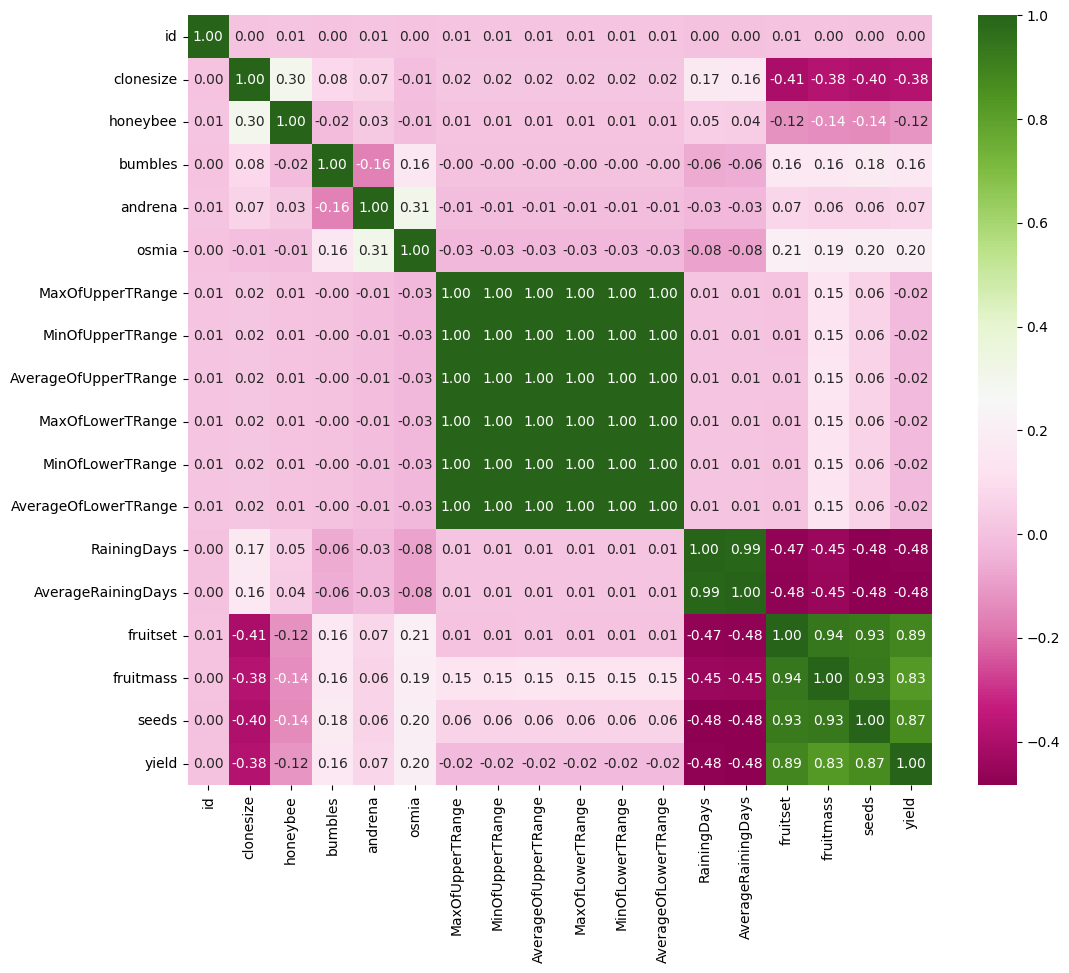

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(), annot=True,cmap='PiYG', fmt=".2f")
plt.show()

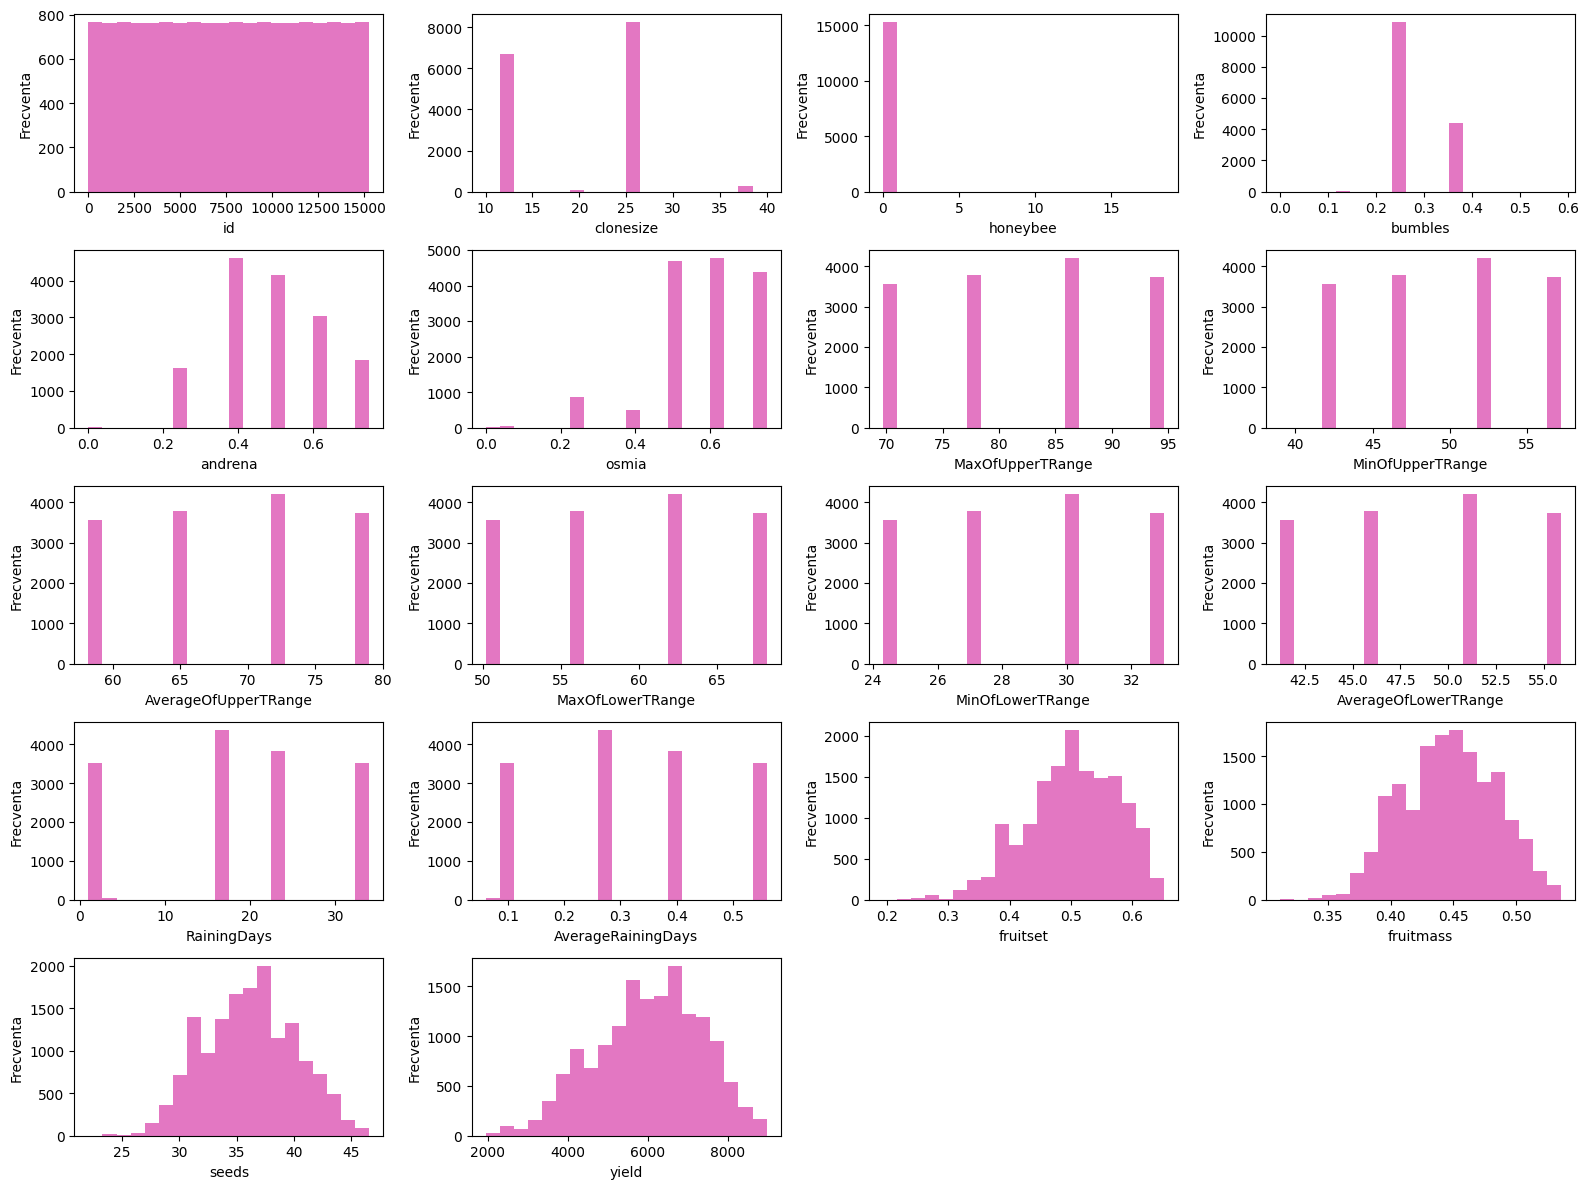

In [ ]:
import matplotlib.pyplot as plt

num_cols = 4
num_rows = (len(train_df.columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(train_df.columns):
    axes[i].hist(train_df[column], bins=20,color='tab:pink')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecventa')

for i in range(len(train_df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [ ]:
cols_to_drop = [ 'MinOfUpperTRange', 'AverageOfUpperTRange', 'AverageOfLowerTRange', 'MaxOfLowerTRange', 'AverageRainingDays']
cols_to_drop2 = [ 'yield','MinOfUpperTRange', 'AverageOfUpperTRange', 'AverageOfLowerTRange', 'MaxOfLowerTRange', 'AverageRainingDays']
X = train_df.drop(cols_to_drop2, axis=1)
y = train_df['yield']
X_test = test_df.drop(cols_to_drop, axis=1)

In [ ]:
X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
cv = RepeatedKFold(n_repeats=3, n_splits=10, random_state=42)

oof_predictions = np.zeros(X.shape[0])
test_predictions = np.zeros(X_test.shape[0])

model_params = {
    'n_jobs': -1,
    'learning_rate': 0.15,
    'max_bin': 100,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'regression_l1',
    'metric': 'mae',
    'verbosity': -1,
    'n_estimators': 2000,
    'random_state': 42
}

In [ ]:
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    print(f'Fold {fold}')

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LGBMRegressor(**model_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mae',
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    pred=model.predict(X_val)
    oof_predictions[val_idx] += pred / 3
    test_predictions += model.predict(X_test) / 30

    fold_mae = mean_absolute_error(y_val, pred)
    print(f'Fold {fold} MAE: {fold_mae}')

Fold 1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l1: 374.496
[200]	valid_0's l1: 374.887
Early stopping, best iteration is:
[44]	valid_0's l1: 372.624
Fold 1 MAE: 372.6242886343233
Fold 2
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l1: 365.654
[200]	valid_0's l1: 365.745
[300]	valid_0's l1: 365.567
Early stopping, best iteration is:
[127]	valid_0's l1: 365.149
Fold 2 MAE: 365.1494097377514
Fold 3
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l1: 334.492
[200]	valid_0's l1: 335.209
[300]	valid_0's l1: 335.83
Early stopping, best iteration is:
[129]	valid_0's l1: 334.205
Fold 3 MAE: 334.2048968844732
Fold 4
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l1: 342.559
[200]	valid_0's l1: 344.057
[300]	valid_0's l1: 344.186
Early stopping, best iteration is:
[123]	valid_0's l1: 342.277
Fold 4 MAE: 342.27741984732586
Fold 5
Training until validation scores don't

In [ ]:
overall_mae = mean_absolute_error(y, oof_predictions)
print(f'Overall MAE: {overall_mae}')

Overall MAE: 345.5026507062257


In [ ]:
submission_df = pd.DataFrame({'id': test_df['id'], 'yield': test_predictions})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>